In [ ]:
#Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed' ) >= 0:  
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug 31 06:49:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
#Check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as img
from PIL import Image
import seaborn as sns

In [ ]:
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 16 kB/s 
     |████████████████████████████████| 463 kB 4.3 MB/s 
     |████████████████████████████████| 1.3 MB 68.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab202207

In [ ]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.1 MB/s 
     |████████████████████████████████| 1.6 MB 13.9 MB/s 


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner import BayesianOptimization
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
import keras_tuner

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """


In [ ]:
keras.backend.clear_session()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/Dissertation')

In [ ]:
# Load the Train and Test Directories
train_dir = '/content/gdrive/My Drive/Dissertation/Tumour/Training'
test_dir  = '/content/gdrive/My Drive/Dissertation/Tumour/Testing'

In [ ]:
from tqdm import tqdm
import cv2
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path +path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path +'/'+ path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


In [ ]:
X_train, y_train, labels = load_data(train_dir, (224,224))
X_test, y_test, _ = load_data(test_dir, (224,224))

100%|██████████| 4/4 [00:56<00:00, 14.10s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


3159 images loaded from /content/gdrive/My Drive/Dissertation/Tumour/Training directory.


100%|██████████| 4/4 [01:05<00:00, 16.42s/it]

394 images loaded from /content/gdrive/My Drive/Dissertation/Tumour/Testing directory.


In [ ]:
from IPython.core.pylabtools import figsize
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
y = dict()
y[0] = []
y[1] = []
y[2] =[]
y[3]=[]
for set_name in (y_train, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))
    y[2].append(np.sum(set_name == 2))
    y[3].append(np.sum(set_name == 3))

trace0 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[0],
    name='Glioma',
    marker=dict(color='#728FCE'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[1],
    name='Meningioma',
    marker=dict(color='#66CDAA'),
    opacity=0.7
)
trace2 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[2],
    name='No Tumor',
    marker=dict(color='#E2F516'),
    opacity=0.7
)
trace3 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[3],
    name='Pituitary',
    marker=dict(color='#FFE4C4'),
    opacity=0.7
)
data = [trace0, trace1,trace2,trace3]
layout = go.Layout(
    title='Tumor data count',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
figsize = (8,8)
iplot(fig)

In [ ]:
import imutils
img = cv2.imread('/content/gdrive/My Drive/Dissertation/Tumour/Training/meningioma_tumor/m (2).jpg')
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()


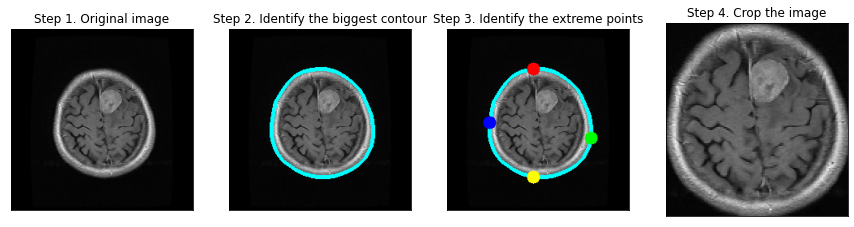

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Identify the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Identify the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
from tqdm import tqdm
import cv2
def load_data1(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    for file in os.listdir(dir_path):
        if not file.startswith('.'):
            img = cv2.imread(dir_path + '/' + file)
            X.append(img)
            y.append(i)
    i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X,y


In [ ]:
train_g_dir = train_dir + '/glioma_tumor/'
test_g_dir = test_dir + '/glioma_tumor/'
X_train_g,y_train_g = load_data1(train_g_dir, (224,224))
X_test_g,y_test_g = load_data1(test_g_dir, (224,224))
train_m_dir = train_dir + '/meningioma_tumor/'
test_m_dir = test_dir + '/meningioma_tumor/'
X_train_m, y_train_m = load_data1(train_m_dir, (224,224))
X_test_m, y_test_m = load_data1(test_m_dir, (224,224))
train_n_dir = train_dir + '/no_tumor/'
test_n_dir = test_dir + '/no_tumor/'
X_train_n, y_train_n = load_data1(train_n_dir, (224,224))
X_test_n, y_test_n = load_data1(test_n_dir, (224,224))
train_p_dir = train_dir + '/pituitary_tumor/'
test_p_dir = test_dir + '/pituitary_tumor/'
X_train_p, y_train_p = load_data1(train_p_dir, (224,224))
X_test_p, y_test_p = load_data1(test_p_dir, (224,224))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



926 images loaded from /content/gdrive/My Drive/Dissertation/Tumour/Training/glioma_tumor/ directory.
100 images loaded from /content/gdrive/My Drive/Dissertation/Tumour/Testing/glioma_tumor/ directory.
832 images loaded from /content/gdrive/My Drive/Dissertation/Tumour/Training/meningioma_tumor/ directory.
115 images loaded from /content/gdrive/My Drive/Dissertation/Tumour/Testing/meningioma_tumor/ directory.
500 images loaded from /content/gdrive/My Drive/Dissertation/Tumour/Training/no_tumor/ directory.
105 images loaded from /content/gdrive/My Drive/Dissertation/Tumour/Testing/no_tumor/ directory.
901 images loaded from /content/gdrive/My Drive/Dissertation/Tumour/Training/pituitary_tumor/ directory.
74 images loaded from /content/gdrive/My Drive/Dissertation/Tumour/Testing/pituitary_tumor/ directory.


In [ ]:
X_train_crop_g = crop_imgs(set_name=X_train_g)
X_test_crop_g = crop_imgs(set_name=X_test_g)
X_train_crop_m = crop_imgs(set_name=X_train_m)
X_test_crop_m = crop_imgs(set_name=X_test_m)
X_train_crop_n = crop_imgs(set_name=X_train_n)
X_test_crop_n = crop_imgs(set_name=X_test_n)
X_train_crop_p = crop_imgs(set_name=X_train_p)
X_test_crop_p = crop_imgs(set_name=X_test_p)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [ ]:
def save_new_images(x_set,y_set, folder_name):
    i = 0
    for (img,imclass) in zip(x_set,y_set):
        cv2.imwrite(folder_name+'G/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
save_new_images(X_train_crop_g,y_train_g, folder_name='/content/gdrive/My Drive/Dissertation/Tumour/Train_Crop/glioma_tumor')

(512, 512, 3)


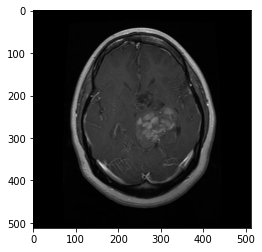

In [ ]:
# Glioma Tumor visualization
img_array = img.imread(train_dir + "/glioma_tumor/gg (1).jpg")
input_shape = img_array.shape
print(input_shape)
plt.imshow(img_array)

(512, 512, 3)


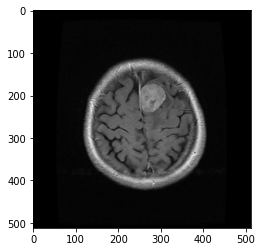

In [ ]:
# Meningioma Tumor visualization
img_array = img.imread(train_dir + "/meningioma_tumor/m (2).jpg")
input_shape = img_array.shape
print(input_shape)
plt.imshow(img_array)

(512, 512, 3)


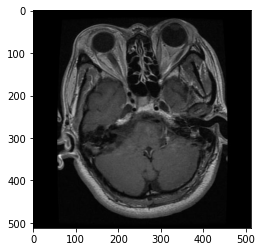

In [ ]:
# Pitutory Tumor visualization
img_array = img.imread(train_dir + "/pituitary_tumor/p (3).jpg")
input_shape = img_array.shape
print(input_shape)
plt.imshow(img_array)

(630, 630, 3)


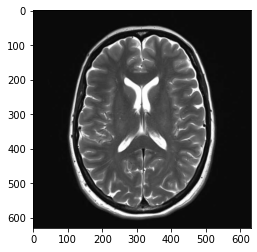

In [ ]:
# Pitutory Tumor visualization
img_array = img.imread(train_dir + "/no_tumor/6.jpg")
input_shape = img_array.shape
print(input_shape)
plt.imshow(img_array)

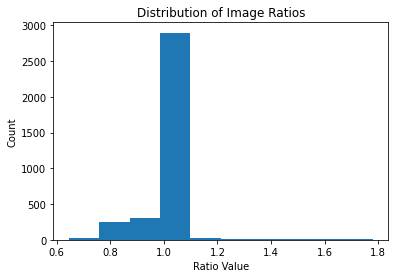

In [ ]:
RATIO_LIST = []
H = []
W = []
for set in (X_train, X_test):
    for img in set:
        H.append(img.shape[1]) 
        W.append(img.shape[0])
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
# sns.distplot(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [ ]:
# find the max and min size of images in each folder
global Size_pic
Size_pic = []
H = []
W = []
def Dimension(paths):
    Sizes = []
    for dirN, _, fileN in os.walk(paths):
        for file in fileN:
            Sizes.append(Image.open(os.path.join(dirN, file), 'r').size)
            Size_pic.append(Image.open(os.path.join(dirN, file), 'r').size)
            # H.append(Sizes[0])
            # W.append(Sizes[1])
    print("Max dim: ", max(Sizes), ", Min dim :", min(Sizes))
    

In [ ]:
#training set max and min dimensions
# Dimension(train_dir + "/glioma_tumor")
# Dimension(train_dir + "/meningioma_tumor")
# Dimension(train_dir + "/no_tumor")
Dimension(train_dir + "/pituitary_tumor")

Max dim:  (1365, 1365) , Min dim : (201, 210)
[(436, 429), (488, 512), (1280, 1280), (502, 502), (685, 681), (202, 202), (502, 502), (488, 512), (400, 400), (202, 202), (225, 225), (1335, 1302), (201, 210), (1358, 1322), (1335, 1302), (225, 225), (512, 512), (350, 400), (474, 474), (201, 210), (512, 512), (474, 474), (625, 603), (474, 474), (625, 603), (512, 512), (624, 607), (624, 607), (442, 442), (201, 210), (1338, 1304), (360, 378), (1358, 1322), (225, 225), (913, 875), (442, 442), (512, 512), (488, 512), (276, 320), (225, 225), (470, 432), (441, 429), (202, 202), (360, 378), (1338, 1304), (350, 400), (441, 429), (1168, 1178), (1338, 1304), (502, 502), (512, 512), (1168, 1178), (512, 512), (442, 442), (1335, 1302), (512, 512), (624, 607), (225, 225), (276, 320), (512, 512), (512, 512), (512, 512), (900, 741), (383, 436), (383, 436), (900, 741), (512, 512), (538, 548), (892, 826), (512, 512), (512, 512), (512, 512), (892, 826), (892, 826), (512, 512), (512, 512), (512, 512), (512, 5

In [ ]:
range(1,len(Size_pic))

range(1, 3159)

In [ ]:
GH = []
GW = []
i= 0
for i in range(0,len(Size_pic)):
  GW.append(Size_pic[i][0])
  GH.append(Size_pic[i][1])

In [ ]:
MH = []
MW = []
i= 0
for i in range(0,len(Size_pic)):
  MW.append(Size_pic[i][0])
  MH.append(Size_pic[i][1])

In [ ]:
NH = []
NW = []
i= 0
for i in range(0,len(Size_pic)):
  NW.append(Size_pic[i][0])
  NH.append(Size_pic[i][1])

In [ ]:
PH = []
PW = []
i= 0
for i in range(0,len(Size_pic)):
  PW.append(Size_pic[i][0])
  PH.append(Size_pic[i][1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/dis

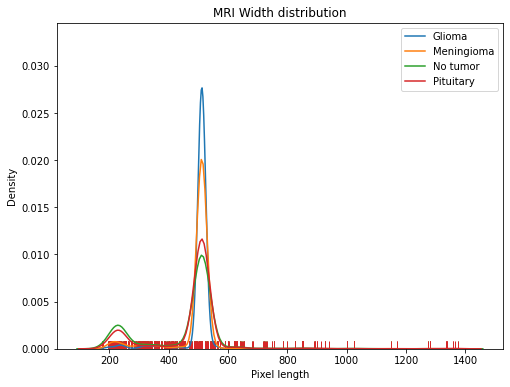

In [ ]:
#Distribution of Image sizes on Train Data
plt.figure(figsize=(8,6))
sns.distplot(W,kde=True,hist=False,rug=True)
sns.distplot(MW,kde=True,hist=False,rug=True)
sns.distplot(NW,kde=True,hist=False,rug=True)
sns.distplot(PW,kde=True,hist=False,rug=True)
plt.legend(labels=["Glioma","Meningioma","No tumor","Pituitary"])
plt.title('MRI Width distribution')
plt.xlabel('Pixel length')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/dis

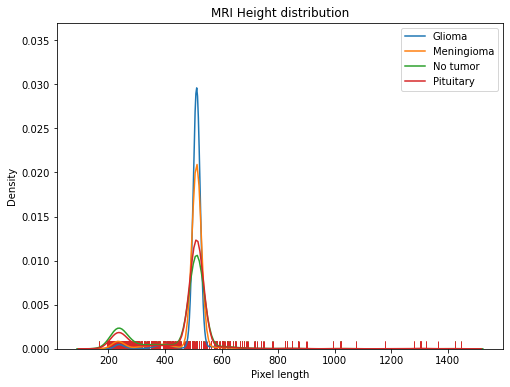

In [ ]:
#Distribution of Image sizes on Train Data
plt.figure(figsize=(8,6))
sns.distplot(H,kde=True,hist=False,rug=True)
sns.distplot(MH,kde=True,hist=False,rug=True)
sns.distplot(NH,kde=True,hist=False,rug=True)
sns.distplot(PH,kde=True,hist=False,rug=True)
plt.legend(labels=["Glioma","Meningioma","No tumor","Pituitary"])
plt.title('MRI Height distribution')
plt.xlabel('Pixel length')

plt.show()

In [ ]:
#testing set max and min dimensions
Dimension(test_dir + "/glioma_tumor")
Dimension(test_dir + "/meningioma_tumor")
Dimension(test_dir + "/no_tumor")
Dimension(test_dir + "/pituitary_tumor")

Max dim:  (640, 480) , Min dim : (175, 167)
Max dim:  (1149, 1019) , Min dim : (174, 230)
Max dim:  (321, 351) , Min dim : (200, 243)
Max dim:  (1358, 1322) , Min dim : (201, 210)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


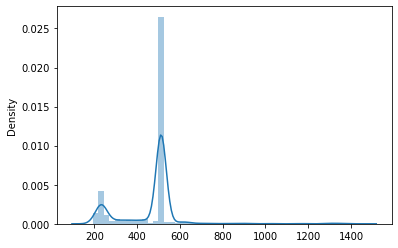

In [ ]:
#Distribution of Image sizes on Test Data
sns.distplot(Size_pic,kde=True)

In [ ]:
#training set max and min dimensions of cropped images
Dimension(train_dir + "/glioma_tumor")
Dimension(train_dir + "/meningioma_tumor")
Dimension(train_dir + "/no_tumor")
Dimension(train_dir + "/pituitary_tumor")

Max dim:  (508, 439) , Min dim : (204, 114)
Max dim:  (1136, 1364) , Min dim : (101, 219)
Max dim:  (1108, 1413) , Min dim : (36, 51)
Max dim:  (1364, 1364) , Min dim : (178, 119)


In [ ]:
#training set max and min dimensions if test cropped images
Dimension(test_dir + "/glioma_tumor")
Dimension(test_dir + "/meningioma_tumor")
Dimension(test_dir + "/no_tumor")
Dimension(test_dir + "/pituitary_tumor")

Max dim:  (571, 535) , Min dim : (128, 155)
Max dim:  (724, 708) , Min dim : (108, 44)
Max dim:  (240, 312) , Min dim : (36, 51)
Max dim:  (1352, 1300) , Min dim : (168, 140)


In [ ]:
# Load the Train and Test Directories for the cropped images
check_dir = '/content/gdrive/My Drive/Dissertation/Tumour/check'

In [ ]:
# Datagenerator for Train,Validation and Test
Generator = ImageDataGenerator(rescale = 1./255
                             ,rotation_range=30
                             ,width_shift_range=.05
                             ,height_shift_range=0.05
                             ,shear_range=30
                             ,zoom_range=.2
                             ,horizontal_flip=True
                             ,vertical_flip=True
                            ,brightness_range = (1,3)

 )
target_labels = ["G"]

In [ ]:
check_generator = Generator.flow_from_directory(check_dir,
                                                target_size=(224,224),
                                                batch_size=1,
                                                color_mode ='rgb',
                                                class_mode='categorical',
                                                classes=target_labels,
                                                shuffle = True,
                                                subset = 'training') 

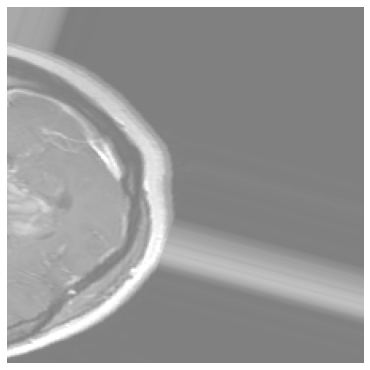

In [ ]:
x_batch, y_batch = next(check_generator)

plt.figure(figsize=(60, 40))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)#4 rows with 8 images.
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [ ]:
# Load the Train and Test Directories for the cropped images
train_dir = '/content/gdrive/My Drive/Dissertation/Tumour/Train_crop'
test_dir  = '/content/gdrive/My Drive/Dissertation/Tumour/Test_crop'

In [ ]:
# Datagenerator for Train,Validation and Test
Generator = ImageDataGenerator(rescale = 1./255,
                               validation_split = 0.25,
                               shear_range=60,
                               zoom_range=.15,
                               rotation_range=90,
                               width_shift_range=0.25,
                               height_shift_range=0.25,
                               horizontal_flip=True,
                               vertical_flip = True
                              #  brightness_range = (0,3)
)
target_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

In [ ]:
train_generator = Generator.flow_from_directory(train_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                color_mode ='rgb',
                                                class_mode='categorical',
                                                classes=target_labels,
                                                # shuffle = True,
                                                seed = 2000,
                                                subset = 'training')   
valid_generator = Generator.flow_from_directory(train_dir,
                                                target_size=(224,224),
                                                batch_size = 32,
                                                color_mode ='rgb',
                                                class_mode='categorical',
                                                classes = target_labels,
                                                # shuffle = True,
                                                seed = 2000,
                                                subset = 'validation')
test_generator = Generator.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                color_mode ='rgb',
                                                class_mode='categorical',
                                                # shuffle = True,
                                                seed = 2000,
                                                classes=target_labels)
print("Training batch classes: ", train_generator.class_indices)
print("Validation batch classes: ", valid_generator.class_indices)
print("Validation batch classes: ", test_generator.class_indices)

Found 2155 images belonging to 4 classes.
Found 715 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Training batch classes:  {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Validation batch classes:  {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Validation batch classes:  {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [ ]:
np.random.seed(100)
tf.random.set_seed(100)

In [ ]:
def plot_cf_matrix(confusion_matrix, axes, class_label, class_names, fontsize = 14):
    df_cm = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cbar = False, ax = axes,cmap='YlOrBr')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("class : " + class_label)

In [ ]:
# Plot confusion matrix 
def plot_confusion_matrices(conf_matrices, target_labels):
    fig, ax = plt.subplots(1, len(target_labels), figsize = (20, 4))

    for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrices, target_labels):
        plot_cf_matrix(cfs_matrix, axes, label, ["No", "Yes"])

    fig.tight_layout()
    plt.show()

In [ ]:
# Test function
def test_model(model, test_gen):
    y_pred = model.predict(x = test_gen, verbose = 1)
    print(y_pred.shape)
    return y_pred

<h1><b>AlexNet implementation

In [ ]:
# Instantiate an empty model    
AlexNet = Sequential()
AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), 
                   padding='same',activation='relu'))# 1st Convolutional Layer
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))# Max Pooling
AlexNet.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same',activation='relu'))# 2nd Convolutional Layer
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))# Max Pooling
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu'))# 3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu'))# 4th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu'))# 5th Convolutional Layer
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))# Max Pooling

In [ ]:
# Fully Connected layer structure
AlexNet.add(Flatten())
AlexNet.add(Dense(4096,activation='relu'))# 1st Fully Connected Layer
AlexNet.add(Dropout(0.1))# Add Dropout to prevent overfitting
AlexNet.add(Dense(4096,activation='relu'))# 2nd Fully Connected Layer
AlexNet.add(Dropout(0.1))# Add Dropout
AlexNet.add(Dense(1000,activation='relu'))# 3rd Fully Connected Layer
AlexNet.add(Dropout(0.5))# Add Dropout
AlexNet.add(Dense(len(target_labels),activation='softmax'))# Output Layer

In [ ]:
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 384)       1

In [ ]:
# AlexNet with Adam Optimizer
AlexNet.compile(loss=keras.losses.categorical_crossentropy,
                optimizer= keras.optimizers.Adam(0.0001),
                metrics=['categorical_accuracy','Recall'])

In [ ]:
# Early Stopping Callback
stop_cb = keras.callbacks.EarlyStopping(patience=40)
mdck_cb = keras.callbacks.ModelCheckpoint(filepath='AlexNet.h5')

In [ ]:
history = AlexNet.fit_generator(train_generator,steps_per_epoch=len(train_generator),
                                epochs=50,
                                validation_data = valid_generator,
                                validation_steps=len(valid_generator),
                                callbacks=[stop_cb,mdck_cb])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
68/68 [==============================] - 126s 2s/step - loss: 1.3326 - categorical_accuracy: 0.2891 - recall: 0.0000e+00 - val_loss: 1.2433 - val_categorical_accuracy: 0.3986 - val_recall: 0.0000e+00
Epoch 2/50
68/68 [==============================] - 129s 2s/step - loss: 1.2477 - categorical_accuracy: 0.3865 - recall: 0.0427 - val_loss: 1.1619 - val_categorical_accuracy: 0.4224 - val_recall: 0.0476
Epoch 3/50
68/68 [==============================] - 133s 2s/step - loss: 1.1553 - categorical_accuracy: 0.4283 - recall: 0.1429 - val_loss: 1.2024 - val_categorical_accuracy: 0.3762 - val_recall: 0.0895
Epoch 4/50
68/68 [==============================] - 137s 2s/step - loss: 1.1278 - categorical_accuracy: 0.4617 - recall: 0.1643 - val_loss: 1.1576 - val_categorical_accuracy: 0.4210 - val_recall: 0.1566
Epoch 5/50
68/68 [==============================] - 132s 2s/step - loss: 1.1255 - categorical_accuracy: 0.4673 - recall: 0.1782 - val_loss: 1.1238 - val_categorical_accuracy: 0.429

In [ ]:
X = pd.DataFrame(history.history)
print('Validation Accuracy:',max(X['val_categorical_accuracy']))
print('Training Accuracy:',max(X['categorical_accuracy']))
print('Validation Recall:',max(X['val_recall']))
print('Training Recall:',max(X['recall']))

Validation Accuracy: 0.6979020833969116
Training Accuracy: 0.7276102304458618
Validation Recall: 0.6363636255264282
Training Recall: 0.670997679233551


In [ ]:
X.to_csv('Alx-TL.csv')

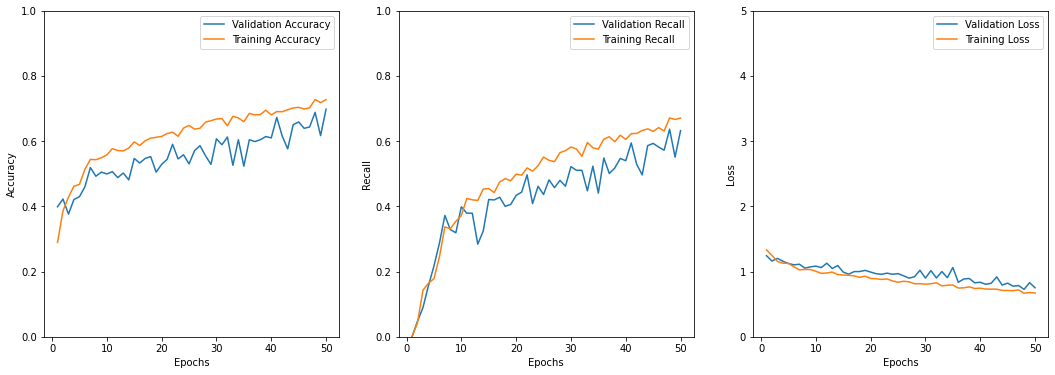

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(np.arange(1,len(X)+1),X['val_categorical_accuracy'],label='Validation Accuracy')
plt.plot(np.arange(1,len(X)+1),X['categorical_accuracy'],label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,2)
plt.plot(np.arange(1,len(X)+1),X['val_recall'],label='Validation Recall')
plt.plot(np.arange(1,len(X)+1),X['recall'],label='Training Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,3)
plt.plot(np.arange(1,len(X)+1),X['val_loss'],label='Validation Loss')
plt.plot(np.arange(1,len(X)+1),X['loss'],label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()

In [ ]:
labelBinarizer = LabelBinarizer() 
test_labels = labelBinarizer.fit_transform(test_generator.labels)

In [ ]:
y_pred = test_model(AlexNet, test_generator)
# y_pred = test_model(model, test_generator)

13/13 [==============================] - 64s 5s/step
(394, 4)


In [ ]:
Y_pred = (y_pred > 0.5).astype(int)

In [ ]:
conf_matrices = multilabel_confusion_matrix(y_true = test_labels, y_pred = Y_pred, labels = [0, 1, 2, 3])

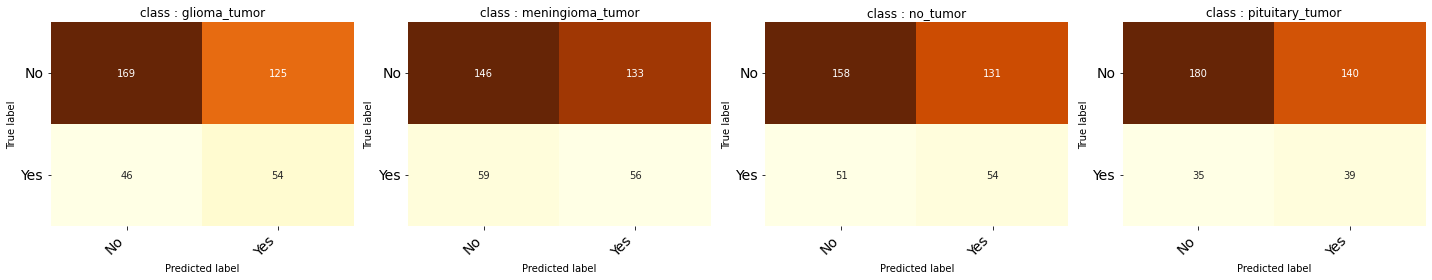

In [ ]:
plot_confusion_matrices(conf_matrices, target_labels)

<h4><b>Hyper Parameter Tuning of AlexNet using Random Search


In [ ]:
def build_AlexNet(param):
  AlexNet1 = Sequential()
  AlexNet1.add(Conv2D(filters=param.Int('Con1_fil',min_value = 96,max_value=128,step=16), 
                      input_shape=(224,224,3), 
                      kernel_size=param.Choice('Con1_krn',values=[10,11,12]), 
                      strides = param.Choice('Con1_str',values=[3,4,5]),
                      padding='same',
                      activation='relu'))
  AlexNet1.add(BatchNormalization())
  AlexNet1.add(MaxPooling2D(pool_size=param.Choice('MxP1_psz',values=[2,3,4]), 
                            strides = param.Choice('MxP1_str',values=[2,3,4]),
                            padding='same'))
  conv2_filter = param.Int('Con2_fil',min_value = 256,max_value=320,step=32)
  conv2_kernel = param.Choice('Con2_krn',values=[4,5,6])
  conv2_stride = param.Choice('Con2_str',values=[3,4,5])
  AlexNet1.add(Conv2D(filters= conv2_filter, 
                      kernel_size=conv2_kernel, 
                      strides = conv2_stride,
                      padding='same',
                      activation='relu'))
  AlexNet1.add(BatchNormalization())
  AlexNet1.add(MaxPooling2D(pool_size=param.Choice('MxP2_psz',values=[2,3,4]), 
                            strides = param.Choice('MxP2_str',values=[2,3,4]),
                            padding='same'))
  conv3_filter = param.Int('Con3_fil',min_value = 384,max_value=448,step=32)
  conv3_kernel = param.Choice('Con3_krn',values=[2,3,4])
  conv3_stride = param.Choice('Con3_str',values=[1,2,3])

  AlexNet1.add(Conv2D(filters=conv3_filter, 
                      kernel_size=conv3_kernel, 
                      strides = conv3_stride,
                      padding='same',
                      activation='relu'))
  AlexNet1.add(BatchNormalization())
  AlexNet1.add(Conv2D(filters=conv3_filter, 
                      kernel_size=conv3_kernel, 
                      strides = conv3_stride,
                      padding='same',
                      activation='relu'))
  AlexNet1.add(BatchNormalization())
  AlexNet1.add(Conv2D(filters=conv2_filter, 
                      kernel_size=conv2_kernel, 
                      strides = conv2_stride,
                      padding='same',
                      activation='relu'))
  AlexNet1.add(BatchNormalization())
  AlexNet1.add(MaxPooling2D(pool_size=param.Choice('MxP3_psz',values=[2,3,4]),
                            strides = param.Choice('MxP3_str',values=[2,3,4]),
                            padding='same'))
  AlexNet1.add(Flatten())
  AlexNet1.add(Dense(units =param.Int('Dens1',min_value=4096,max_value=4622,step=256), 
                     activation='relu'))
  AlexNet1.add(Dropout(param.Choice('Dropout1',values=[0.2,0.4,0.6])))
  AlexNet1.add(Dense(units =param.Int('Dens2',min_value=4096,max_value=4622,step=256),
                     activation='relu'))
  AlexNet1.add(Dropout(param.Choice('Dropout2',values=[0.3,0.5,0.7])))
  AlexNet1.add(Dense(units =param.Int('Dens3',min_value=1000,max_value=1256,step=128),
                     activation='relu'))
  AlexNet1.add(Dropout(param.Choice('Dropout3',values=[0.2,0.3,0.4])))
  AlexNet1.add(Dense(len(target_labels),activation='softmax'))
  
  AlexNet1.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer= keras.optimizers.Adam(param.Choice('learning_rate',values=[5e-4,1e-4])),
                   metrics=['categorical_accuracy','Recall'])
  return AlexNet1

In [ ]:
Alexnet_bo_tuner = BayesianOptimization(build_AlexNet,
                            objective=[
                                keras_tuner.Objective('val_recall',direction='max'),
                                keras_tuner.Objective('val_categorical_accuracy',direction='max'),
                                keras_tuner.Objective('val_loss',direction='min')],
                            max_trials=5,
                            # num_initial_points = 2,
                            # alpha = 0.0001,
                            directory ='AlexNet_BO',
                            project_name='Dissert',
                            overwrite=True)

In [ ]:
Alexnet_bo_tuner.search(train_generator,epochs=6,validation_data=valid_generator)

Trial 5 Complete [00h 03m 57s]
multi_objective: 0.8655170984566212

Best multi_objective So Far: 0.4740678369998932
Total elapsed time: 00h 24m 26s


In [ ]:
Alexnet_bo_tuner.get_best_hyperparameters(1)[0].values

{'Con1_fil': 128,
 'Con1_krn': 10,
 'Con1_str': 3,
 'MxP1_psz': 4,
 'MxP1_str': 2,
 'Con2_fil': 320,
 'Con2_krn': 4,
 'Con2_str': 5,
 'MxP2_psz': 4,
 'MxP2_str': 2,
 'Con3_fil': 448,
 'Con3_krn': 4,
 'Con3_str': 3,
 'MxP3_psz': 2,
 'MxP3_str': 4,
 'Dens1': 4096,
 'Dropout1': 0.4,
 'Dens2': 4096,
 'Dropout2': 0.3,
 'Dens3': 1000,
 'Dropout3': 0.3,
 'learning_rate': 0.0005}

In [ ]:
Alexnet_bo_tuner.results_summary()

Results summary
Results in AlexNet_BO/Dissert
Showing 10 best trials
Trial summary
Hyperparameters:
Con1_fil: 128
Con1_krn: 10
Con1_str: 3
MxP1_psz: 4
MxP1_str: 2
Con2_fil: 320
Con2_krn: 4
Con2_str: 5
MxP2_psz: 4
MxP2_str: 2
Con3_fil: 448
Con3_krn: 4
Con3_str: 3
MxP3_psz: 2
MxP3_str: 4
Dens1: 4096
Dropout1: 0.4
Dens2: 4096
Dropout2: 0.3
Dens3: 1000
Dropout3: 0.3
learning_rate: 0.0005
Score: 0.4740678369998932
Trial summary
Hyperparameters:
Con1_fil: 128
Con1_krn: 10
Con1_str: 3
MxP1_psz: 3
MxP1_str: 2
Con2_fil: 288
Con2_krn: 6
Con2_str: 4
MxP2_psz: 4
MxP2_str: 3
Con3_fil: 448
Con3_krn: 3
Con3_str: 3
MxP3_psz: 2
MxP3_str: 4
Dens1: 4096
Dropout1: 0.4
Dens2: 4096
Dropout2: 0.3
Dens3: 1000
Dropout3: 0.3
learning_rate: 0.0005
Score: 0.47673213481903076
Trial summary
Hyperparameters:
Con1_fil: 128
Con1_krn: 11
Con1_str: 3
MxP1_psz: 2
MxP1_str: 2
Con2_fil: 288
Con2_krn: 6
Con2_str: 5
MxP2_psz: 3
MxP2_str: 4
Con3_fil: 448
Con3_krn: 2
Con3_str: 3
MxP3_psz: 2
MxP3_str: 4
Dens1: 4096
Dropout1: 0.

In [ ]:
alex = Alexnet_bo_tuner.get_best_models(4)

In [ ]:
alex[1].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 128)       38528     
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 38, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 288)       1327392   
                                                                 
 batch_normalization_1 (Batc  (None, 10, 10, 288)      1152      
 hNormalization)                                                 
                                                        

In [ ]:
mdck_cb = keras.callbacks.ModelCheckpoint(filepath='AlexNetHP.h5')
stop_cb = keras.callbacks.EarlyStopping(patience=45)
hist00 = alex[0].fit_generator(train_generator,steps_per_epoch=len(train_generator),
                                epochs=50,verbose =1,
                                validation_data = valid_generator,validation_steps=len(valid_generator),
                                callbacks=[stop_cb,mdck_cb])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
68/68 [==============================] - 49s 712ms/step - loss: 1.0651 - categorical_accuracy: 0.5490 - recall: 0.3726 - val_loss: 1.3131 - val_categorical_accuracy: 0.4154 - val_recall: 0.3860
Epoch 2/50
68/68 [==============================] - 42s 620ms/step - loss: 1.0515 - categorical_accuracy: 0.5420 - recall: 0.3666 - val_loss: 1.3160 - val_categorical_accuracy: 0.4238 - val_recall: 0.3231
Epoch 3/50
68/68 [==============================] - 42s 621ms/step - loss: 1.0601 - categorical_accuracy: 0.5457 - recall: 0.3346 - val_loss: 1.0034 - val_categorical_accuracy: 0.5455 - val_recall: 0.3818
Epoch 4/50
68/68 [==============================] - 42s 624ms/step - loss: 0.9873 - categorical_accuracy: 0.5833 - recall: 0.4269 - val_loss: 1.2558 - val_categorical_accuracy: 0.4350 - val_recall: 0.3748
Epoch 5/50
68/68 [==============================] - 43s 637ms/step - loss: 0.9724 - categorical_accuracy: 0.5954 - recall: 0.4469 - val_loss: 1.2161 - val_categorical_accuracy: 0.5

In [ ]:
hist01 = alex[1].fit_generator(train_generator,steps_per_epoch=len(train_generator),
                                epochs=50,verbose =1,
                                validation_data = valid_generator,validation_steps=len(valid_generator))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
68/68 [==============================] - 40s 575ms/step - loss: 1.0917 - categorical_accuracy: 0.5299 - recall: 0.3313 - val_loss: 1.1296 - val_categorical_accuracy: 0.4727 - val_recall: 0.3245
Epoch 2/50
68/68 [==============================] - 37s 550ms/step - loss: 1.0442 - categorical_accuracy: 0.5647 - recall: 0.3791 - val_loss: 1.1069 - val_categorical_accuracy: 0.5147 - val_recall: 0.3972
Epoch 3/50
68/68 [==============================] - 37s 548ms/step - loss: 1.0778 - categorical_accuracy: 0.5425 - recall: 0.3517 - val_loss: 1.0709 - val_categorical_accuracy: 0.5147 - val_recall: 0.3818
Epoch 4/50
68/68 [==============================] - 37s 551ms/step - loss: 1.0332 - categorical_accuracy: 0.5684 - recall: 0.3870 - val_loss: 1.0788 - val_categorical_accuracy: 0.4685 - val_recall: 0.3245
Epoch 5/50
68/68 [==============================] - 38s 553ms/step - loss: 1.0197 - categorical_accuracy: 0.5592 - recall: 0.3768 - val_loss: 1.2808 - val_categorical_accuracy: 0.4

In [ ]:
hist02 = alex[2].fit_generator(train_generator,steps_per_epoch=len(train_generator),
                                epochs=50,verbose =1,
                                validation_data = valid_generator,validation_steps=len(valid_generator))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
68/68 [==============================] - 39s 557ms/step - loss: 1.1508 - categorical_accuracy: 0.4357 - recall: 0.1842 - val_loss: 1.0948 - val_categorical_accuracy: 0.5007 - val_recall: 0.1636
Epoch 2/50
68/68 [==============================] - 38s 553ms/step - loss: 1.1387 - categorical_accuracy: 0.4798 - recall: 0.2009 - val_loss: 1.2040 - val_categorical_accuracy: 0.4476 - val_recall: 0.2797
Epoch 3/50
68/68 [==============================] - 37s 546ms/step - loss: 1.1222 - categorical_accuracy: 0.4840 - recall: 0.2343 - val_loss: 1.1019 - val_categorical_accuracy: 0.4811 - val_recall: 0.3245
Epoch 4/50
68/68 [==============================] - 37s 548ms/step - loss: 1.1121 - categorical_accuracy: 0.4900 - recall: 0.2561 - val_loss: 1.1894 - val_categorical_accuracy: 0.4559 - val_recall: 0.2727
Epoch 5/50
68/68 [==============================] - 38s 554ms/step - loss: 1.1084 - categorical_accuracy: 0.4826 - recall: 0.2492 - val_loss: 1.1391 - val_categorical_accuracy: 0.4

In [ ]:
hist03 = alex[3].fit_generator(train_generator,steps_per_epoch=len(train_generator),
                                epochs=50,verbose =1,
                                validation_data = valid_generator,validation_steps=len(valid_generator))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
68/68 [==============================] - 40s 573ms/step - loss: 1.1196 - categorical_accuracy: 0.4933 - recall: 0.2622 - val_loss: 1.5219 - val_categorical_accuracy: 0.3371 - val_recall: 0.2881
Epoch 2/50
68/68 [==============================] - 37s 549ms/step - loss: 1.1253 - categorical_accuracy: 0.4886 - recall: 0.2682 - val_loss: 1.9555 - val_categorical_accuracy: 0.3566 - val_recall: 0.2993
Epoch 3/50
68/68 [==============================] - 37s 552ms/step - loss: 1.0949 - categorical_accuracy: 0.5118 - recall: 0.2780 - val_loss: 1.0550 - val_categorical_accuracy: 0.5273 - val_recall: 0.2531
Epoch 4/50
68/68 [==============================] - 38s 555ms/step - loss: 1.0661 - categorical_accuracy: 0.5276 - recall: 0.3002 - val_loss: 1.5063 - val_categorical_accuracy: 0.3874 - val_recall: 0.3427
Epoch 5/50
68/68 [==============================] - 37s 550ms/step - loss: 1.0635 - categorical_accuracy: 0.5253 - recall: 0.3007 - val_loss: 1.6729 - val_categorical_accuracy: 0.2

In [ ]:
hist04 = alex1[4].fit_generator(train_generator,steps_per_epoch=len(train_generator),
                                epochs=50,verbose =1,
                                validation_data = valid_generator,validation_steps=len(valid_generator))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
68/68 [==============================] - 40s 571ms/step - loss: 0.9979 - categorical_accuracy: 0.5624 - recall: 0.4195 - val_loss: 1.3349 - val_categorical_accuracy: 0.3552 - val_recall: 0.2797
Epoch 2/50
68/68 [==============================] - 38s 560ms/step - loss: 0.9768 - categorical_accuracy: 0.5708 - recall: 0.4515 - val_loss: 1.4663 - val_categorical_accuracy: 0.3035 - val_recall: 0.2182
Epoch 3/50
68/68 [==============================] - 38s 560ms/step - loss: 0.9506 - categorical_accuracy: 0.5921 - recall: 0.4664 - val_loss: 2.0490 - val_categorical_accuracy: 0.1734 - val_recall: 0.1510
Epoch 4/50
68/68 [==============================] - 37s 552ms/step - loss: 0.9272 - categorical_accuracy: 0.6037 - recall: 0.4840 - val_loss: 1.2290 - val_categorical_accuracy: 0.4168 - val_recall: 0.2769
Epoch 5/50
68/68 [==============================] - 37s 550ms/step - loss: 0.8924 - categorical_accuracy: 0.6237 - recall: 0.5095 - val_loss: 1.2366 - val_categorical_accuracy: 0.4

In [ ]:
# X = pd.DataFrame(history.history)
Y0 = pd.DataFrame(hist00.history)
Y1 = pd.DataFrame(hist01.history)
Y2 = pd.DataFrame(hist02.history)
Y3 = pd.DataFrame(hist03.history)
Y4 = pd.DataFrame(hist04.history)

In [ ]:
Y0.to_csv('Alex00.csv')
Y1.to_csv('Alex01.csv')
Y2.to_csv('Alex02.csv')
Y3.to_csv('Alex03.csv')
Y4.to_csv('Alex04.csv')

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
X = pd.read_csv('/content/gdrive/My Drive/Dissertation/Alx-TL.csv')
Y0 = pd.read_csv('/content/gdrive/My Drive/Dissertation/Alex00.csv')
Y1 = pd.read_csv('/content/gdrive/My Drive/Dissertation/Alex01.csv')
Y2 = pd.read_csv('/content/gdrive/My Drive/Dissertation/Alex02.csv')
Y3 = pd.read_csv('/content/gdrive/My Drive/Dissertation/Alex03.csv')
Y4 = pd.read_csv('/content/gdrive/My Drive/Dissertation/Alex04.csv')

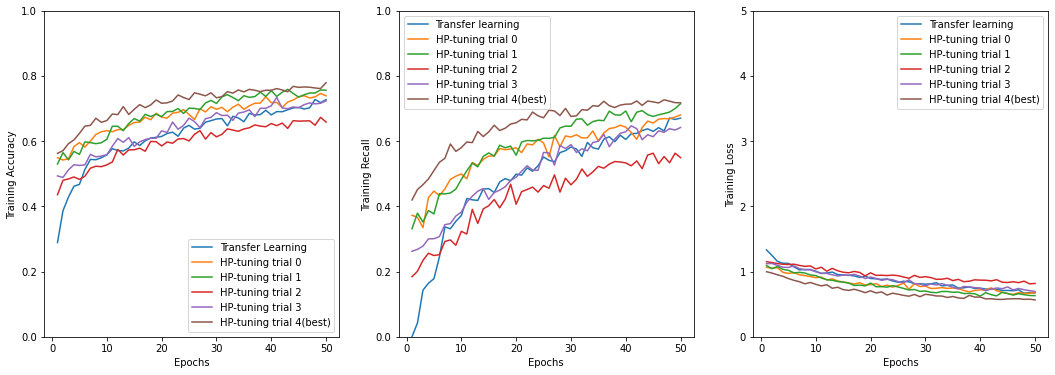

In [ ]:

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(np.arange(1,len(X)+1),X['categorical_accuracy'],label='Transfer Learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['categorical_accuracy'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['categorical_accuracy'],label='HP-tuning trial 1')
plt.plot(np.arange(1,len(Y2)+1),Y2['categorical_accuracy'],label='HP-tuning trial 2')
plt.plot(np.arange(1,len(Y3)+1),Y3['categorical_accuracy'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['categorical_accuracy'],label='HP-tuning trial 4(best)')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,2)
plt.plot(np.arange(1,len(X)+1),X['recall'],label='Transfer learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['recall'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['recall'],label='HP-tuning trial 1')
plt.plot(np.arange(1,len(Y2)+1),Y2['recall'],label='HP-tuning trial 2')
plt.plot(np.arange(1,len(Y3)+1),Y3['recall'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['recall'],label='HP-tuning trial 4(best)')
plt.xlabel('Epochs')
plt.ylabel('Training Recall')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,3)
plt.plot(np.arange(1,len(X)+1),X['loss'],label='Transfer learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['loss'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['loss'],label='HP-tuning trial 1')
plt.plot(np.arange(1,len(Y2)+1),Y2['loss'],label='HP-tuning trial 2')
plt.plot(np.arange(1,len(Y3)+1),Y3['loss'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['loss'],label='HP-tuning trial 4(best)')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.ylim(0,5)
plt.legend()

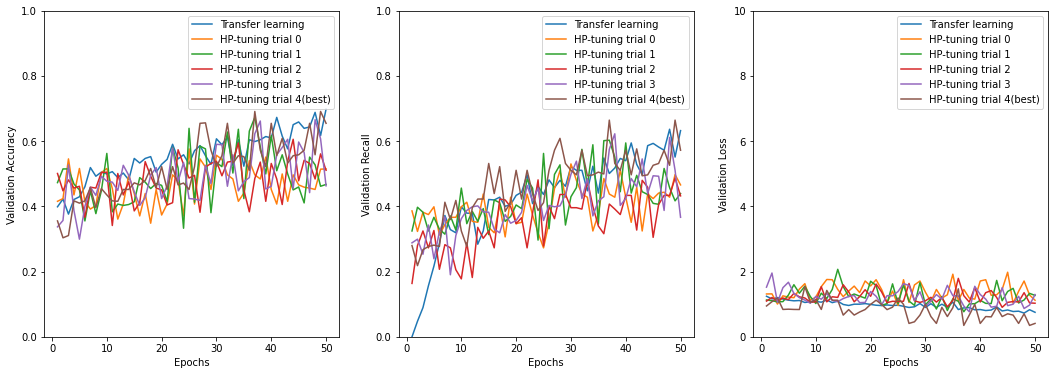

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(np.arange(1,len(X)+1),X['val_categorical_accuracy'],label='Transfer learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['val_categorical_accuracy'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['val_categorical_accuracy'],label='HP-tuning trial 1')
plt.plot(np.arange(1,len(Y2)+1),Y2['val_categorical_accuracy'],label='HP-tuning trial 2')
plt.plot(np.arange(1,len(Y3)+1),Y3['val_categorical_accuracy'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['val_categorical_accuracy'],label='HP-tuning trial 4(best)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,2)
plt.plot(np.arange(1,len(X)+1),X['val_recall'],label='Transfer learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['val_recall'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['val_recall'],label='HP-tuning trial 1')
plt.plot(np.arange(1,len(Y2)+1),Y2['val_recall'],label='HP-tuning trial 2')
plt.plot(np.arange(1,len(Y3)+1),Y3['val_recall'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['val_recall'],label='HP-tuning trial 4(best)')
plt.xlabel('Epochs')
plt.ylabel('Validation Recall')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,3)
plt.plot(np.arange(1,len(X)+1),X['val_loss'],label='Transfer learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['val_loss'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['val_loss'],label='HP-tuning trial 1')
plt.plot(np.arange(1,len(Y2)+1),Y2['val_loss'],label='HP-tuning trial 2')
plt.plot(np.arange(1,len(Y3)+1),Y3['val_loss'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['val_loss'],label='HP-tuning trial 4(best)')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.ylim(0,10)
plt.legend()

<h3><b>Model testing</h3>

In [ ]:
model = keras.models.load_model('/content/gdrive/My Drive/Dissertation/AlexNetHP.h5')

In [ ]:
# y_pred = test_model(Alexbest_bo, test_generator)
y_pred = test_model(model, test_generator)

13/13 [==============================] - 8s 594ms/step
(394, 4)


In [ ]:
Y_pred = (y_pred > 0.5).astype(int)

In [ ]:
labelBinarizer = LabelBinarizer() 
test_labels = labelBinarizer.fit_transform(test_generator.labels)

In [ ]:
conf_matrices = multilabel_confusion_matrix(y_true = test_labels, y_pred = Y_pred, labels = [0, 1, 2, 3])

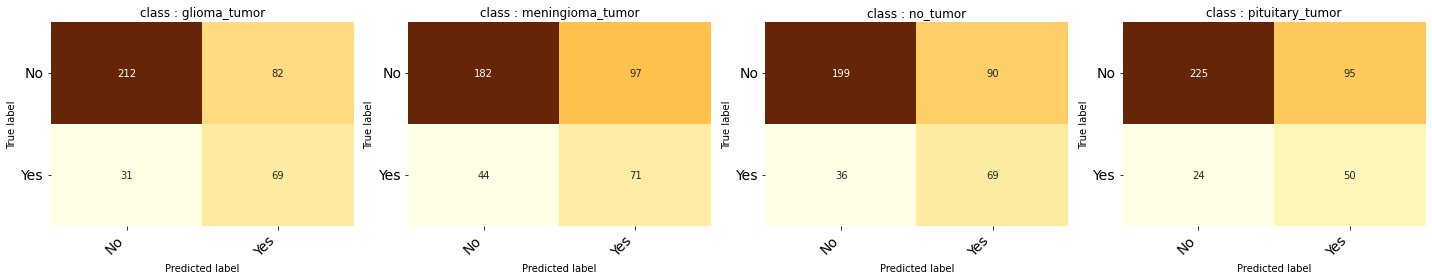

In [ ]:
plot_confusion_matrices(conf_matrices, target_labels)